In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-10-06T22:26:28.828656+03:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.21.0

Compiler    : GCC 14.2.1 20240921
OS          : Linux
Release     : 6.11.0-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [5]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [6]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)
        area = requests.get(
            f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-10-05: 100%|██████████| 1059/1059 [03:59<00:00,  4.43it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
5478,#ff5252,139991.513798,23.189,other_territories,2024-10-05 23:37:09
5479,#880e4f,43974.128584,7.284,occupied_to_24_02_2022,2024-10-05 23:37:09
5480,#a52714,66298.286987,10.982,occupied_after_24_02_2022,2024-10-05 23:37:09
5481,#bdbdbd,345.691239,0.057,other_territories,2024-10-05 23:37:09


In [7]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [8]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [9]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [10]:
df

,hash,area,percent,type
time_index,,,,
2022-04-03 15:33:28,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
2022-04-03 15:33:28,#880e4f,46937.208199,7.775000,occupied_to_24_02_2022
2022-04-03 15:33:28,#bcaaa4,5587.522472,0.926000,unspecified
2022-04-03 15:33:28,#0f9d58,14012.882652,2.321000,liberated
2022-04-03 19:46:15,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
...,...,...,...,...
2024-10-05 23:37:09,#ff5252,139991.513798,23.188999,other_territories
2024-10-05 23:37:09,#880e4f,43974.128584,7.284000,occupied_to_24_02_2022
2024-10-05 23:37:09,#a52714,66298.286987,10.982000,occupied_after_24_02_2022


In [11]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_2344/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [12]:
occupied_by_ua = (
    df[
        (df["type"] == "other_territories") &
        (df['hash'] == '#01579b')
    ]
    .groupby(pd.Grouper(freq="D"))[["area", "percent"]]
    .mean()
    .fillna(0)
)
occupied_by_ua

,area,percent
time_index,,
2024-08-08,142.989574,0.024
2024-08-09,142.989574,0.024
2024-08-10,142.989574,0.024
2024-08-11,142.989574,0.024
2024-08-12,313.306949,0.052
2024-08-13,313.483165,0.052
2024-08-14,469.022292,0.078
2024-08-15,507.762966,0.084
2024-08-16,532.395801,0.088


In [13]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-10-05                    liberated
2024-10-05    occupied_after_24_02_2022
2024-10-05       occupied_to_24_02_2022
2024-10-05            other_territories
2024-10-05                  unspecified
Name: type, Length: 4149, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [14]:
area_dinamic["type"].unique()

['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'unspecified', 'other_territories']
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [15]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [16]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [17]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-10-01,66245.470002,0
2024-10-02,66247.352757,0
2024-10-03,66261.315358,0
2024-10-04,66291.173018,0


In [18]:
aa['area'] = aa['area'].subtract(occupied_by_ua['area'], fill_value=0)
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-10-01,65452.521927,0
2024-10-02,65459.424866,0
2024-10-03,65473.387467,0
2024-10-04,65503.245127,0


In [19]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     760.8
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:30:31   Log-Likelihood:                -8410.7
No. Observations:                 917   AIC:                         1.684e+04
Df Residuals:                     910   BIC:                         1.687e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)   978.6752    135.510      7.222      0.000     712.727    1244.623
cos(1,730.50)  2472.1959    204.360     12.097      0.000    2071.124    2873.268
sin(2,730.50)  2238.3563    130.987     17.088      0.000    1981.285    2495.427
cos(2,730.50)  -638.9911    129.788     -4.923      0.000    -893.710    -384.272
prefix         3658.5599    586.713      6.236      0.000    2507.091    4810.028
const          7.108e+04    488.805    145.416      0.000    7.01e+04     7.2e+04
trend           -10.8333      0.837    -12.944      0.000     -12.476      -9.191
==============================================================================
Omnibus:                      307.764   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1906.747
Skew:                          -1.388   Prob(JB):                         0.00
Kurtosis:                       9.496   Cond. No.                     5.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

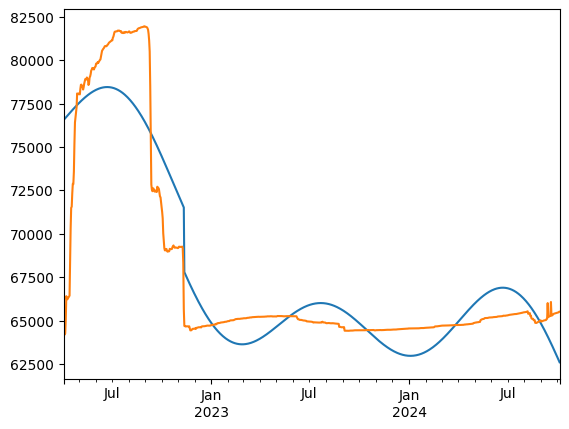

In [20]:
best_ff.predict(ff).plot()
aa["area"].plot()

In [21]:
aa.loc["2022-02-03":]

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-10-01,65452.521927,0
2024-10-02,65459.424866,0
2024-10-03,65473.387467,0
2024-10-04,65503.245127,0


In [22]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

,ru_holiday,ua_holiday,const,trend
2022-04-03,0,0,1.0,1.0
2022-04-04,0,0,1.0,2.0
2022-04-05,0,0,1.0,3.0
2022-04-06,0,0,1.0,4.0
2022-04-07,0,0,1.0,5.0
...,...,...,...,...
2024-10-01,0,0,1.0,913.0
2024-10-02,0,0,1.0,914.0
2024-10-03,0,0,1.0,915.0
2024-10-04,0,0,1.0,916.0


In [23]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  917
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -6095.639
Date:                Sun, 06 Oct 2024   AIC                          12203.277
Time:                        22:30:42   BIC                          12232.197
Sample:                    04-03-2022   HQIC                         12214.316
                         - 10-05-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7117      0.069     10.317      0.000       0.577       0.847
ar.L2          0.2518      0.062      4.050      0.000       0.130       0.374
ma.L1         -0.1104      0.069     -1.608      0.108      -0.245       0.024
ma.L2         -0.4412      0.028    -15.731      0.000      -0.496      -0.386
ma.L3         -0.3016      0.032     -9.487      0.000      -0.364      -0.239
sigma2      3.295e+04    318.154    103.578      0.000    3.23e+04    3.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.91   Jarque-Bera (JB):            126612.63
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -3.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        60.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-10-06,65513.008671,181.531580,65157.213311,65868.804030
2024-10-07,65516.099325,342.719520,64844.381408,66187.817241
2024-10-08,65522.628974,478.553607,64584.681140,66460.576807
2024-10-09,65528.054455,585.628641,64380.243410,66675.865501
2024-10-10,65533.559888,682.759306,64195.376238,66871.743538
...,...,...,...,...
2025-01-29,65709.321029,6645.655106,52684.076368,78734.565689
2025-01-30,65709.523362,6684.129848,52608.869591,78810.177132
2025-01-31,65709.719830,6722.427882,52534.003292,78885.436367
2025-02-01,65709.910603,6760.550981,52459.474166,78960.347041


In [25]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha /
     100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [26]:
country_area = {
    'Черногория': 14026,
    'Словения': 20253,
    'Северная Македония': 25333,
    'Албания': 28748,
    'Бельгия': 32528,
    'Молдавия': 33843,
    'Швейцария': 41290,
    'Нидерланды': 41526,
    'Дания': 42895,
    'Эстония': 45226,
    'Босния и Герцеговина': 51129,
    'Хорватия': 56542,
    'Латвия': 64589,
    'Литва': 65200,
    'Ирландия': 70273,
    'Чехия': 78866,
    'Австрия': 83858
}

In [27]:
max_idx = aa.iloc[-365-14:-14]['area'].idxmax()
max_val = round(aa.iloc[-365-14:-14]['area'].max()/1000, 1)

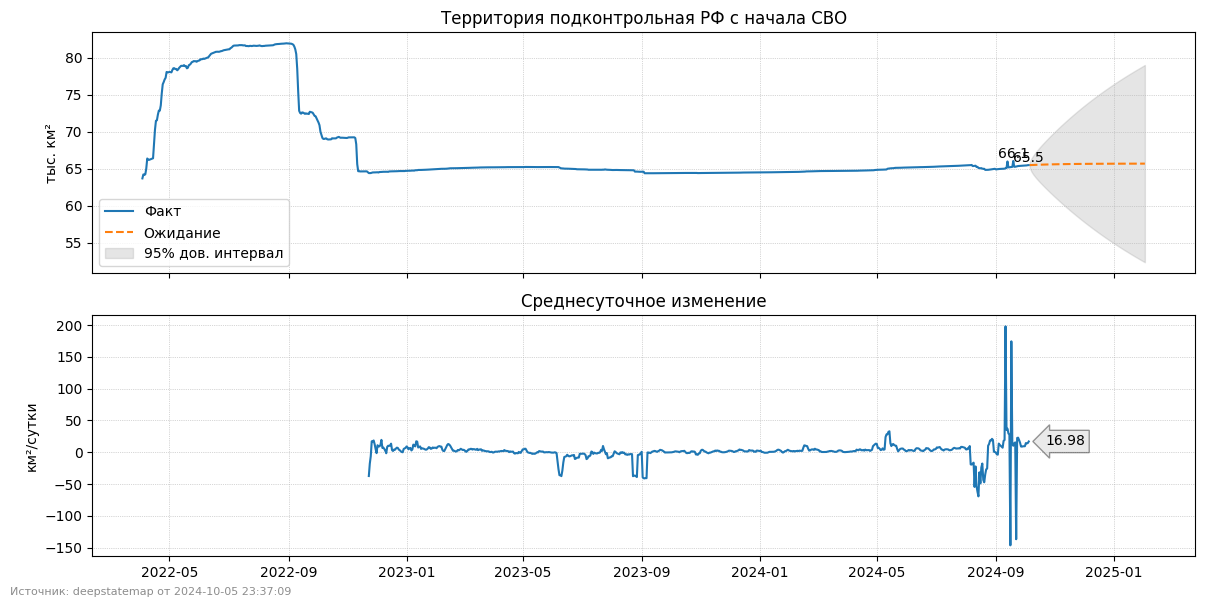

In [28]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)

ax.text(max_idx, max_val,
        f'{max_val:.1f}', ha='center', va='bottom')

ax.text(aa['area'].index.max(), aa['area'].iloc[-1] /
        1000, f'{aa['area'].iloc[-1]/1000:.1f}', ha='center', va='bottom')

ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = (
    aa.diff()["2022-11-23":].rolling(5, center=True,
                                     min_periods=3).mean()
)
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=16 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)